In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayusingh22","key":"9100f8d48652377c0b5e5b8763432a27"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!kaggle competitions download -c digit-recognizer
!unzip test.zip
!unzip train.zip
!unzip sample_submission.zip

 78% 57.0M/73.2M [00:00<00:00, 134MB/s]
100% 73.2M/73.2M [00:00<00:00, 136MB/s]
 88% 43.0M/48.8M [00:00<00:00, 187MB/s]
100% 48.8M/48.8M [00:00<00:00, 193MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 211MB/s]
unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.
unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.
unzip:  cannot find or open sample_submission.zip, sample_submission.zip.zip or sample_submission.zip.ZIP.


In [0]:
import keras
import shutil
import keras
from keras.models import Model,Sequential
from keras.layers import *
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.preprocessing import OneHotEncoder
import scipy.ndimage

In [0]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
sample=pd.read_csv("sample_submission.csv")

In [0]:
labels=train["label"]
train.drop(columns=["label"],inplace=True)

In [0]:
x_train=np.empty((42000,28,28,1),np.uint8)
for i in range(42000):
  x_train[i]=np.array(train.iloc[[i]]).reshape(28,28,1)
  
x_test=np.empty((28000,28,28,1),np.uint8)
for i in range(28000):
  x_test[i]=np.array(test.iloc[[i]]).reshape(28,28,1)

In [0]:
y=pd.get_dummies(labels)

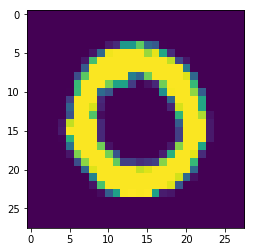

In [0]:
plt.imshow(x_train[1])

In [0]:
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(x_train, y, test_size=0.1, random_state=42)

In [0]:
from keras.utils import Sequence
import math
class datagen(Sequence):
  def __init__(self,labels,batch_size,image_size):
    self.target=labels
    self.batch_length=batch_size
    self.image_length=image_size
    self.size=len(labels)
  def __getitem__(self,i):
    start=i*self.batch_length
    end=min((i+1)*self.batch_length,self.size)
    train_img=np.empty(((end-start)*5,self.image_length,self.image_length,1),'uint8')
    a=0
    for x in range(start,end):
      img = x_tr[x]
      num_x = np.random.randint(0,3)
      num_y = np.random.randint(0,3)
      img_ran = img[num_x:num_x+24, num_y:num_y+24]
      rot_ran = np.random.randint(1,10)
      rot_ran_neg = np.random.randint(1,10)
      rot_img_pos = ndimage.rotate(img_ran, rot_ran)
      rot_img_neg = ndimage.rotate(img_ran, -rot_ran_neg)
      rot_pos = cv2.resize(rot_img_pos,(24,24)).reshape((24,24,1))
      rot_neg = cv2.resize(rot_img_neg,(24,24)).reshape((24,24,1))
      rows,cols,d = img_ran.shape
      ran_shift_x = np.random.randint(1,3)
      ran_shift_y = np.random.randint(1,3)
      M = np.float32([[1,0,ran_shift_x],[0,1,ran_shift_y]])
      img_shift = cv2.warpAffine(img,M,(cols,rows)).reshape((24,24,1))
      ran_shift_x_new = np.random.randint(1,3)
      ran_shift_y_new = np.random.randint(1,3)
      img_sh_base = cv2.resize(img,(24,24))
      M = np.float32([[1,0,ran_shift_x],[0,1,ran_shift_y]])
      img_shift_new = cv2.warpAffine(img_sh_base,M,(cols,rows)).reshape((24,24,1))
      
        
      
      train_img[a] = img_ran
      train_img[a + end-start] = rot_pos
      train_img[a + 2*(end-start)] = rot_neg
      train_img[a + 3*(end-start)] = img_shift
      train_img[a + 4*(end-start)] = img_shift_new
      
      a=a+1
      
    Y_train=self.target[start:end]
    y_train=np.concatenate((Y_train,Y_train,Y_train,Y_train,Y_train),axis=0)
    return (train_img,y_train)
  def __len__(self):
    return math.ceil(self.size/self.batch_length)

In [0]:
from keras.utils import Sequence
import math
class datagen1(Sequence):
    
  def __init__(self,labels,batch_size,image_size):
    self.target=labels
    self.batch_length=batch_size
    self.image_length=image_size
    self.size=len(labels)
  def __getitem__(self,i):
    start=i*self.batch_length
    end=min((i+1)*self.batch_length,self.size)
    train_img=np.empty((end-start,self.image_length,self.image_length,1),'uint8')
    a=0
    for x in range(start,end):
      img = x_te[x]
      img = cv2.resize(img, (24,24)).reshape((24,24,1))
      train_img[a]=img
      a=a+1
    y_train=self.target[start:end]
    
    return (train_img,y_train)
  def __len__(self):
    return math.ceil(self.size/self.batch_length)

In [0]:
traingen=datagen(y_tr,64,24)
valgen=datagen1(y_te,64,24)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.000000001)

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)

In [0]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(24,24,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 24, 24, 32)        320       
_________________________________________________________________
activation_19 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_20 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 32)        9248      
__________

In [0]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=adam ,metrics=['acc'])

In [0]:
model.fit_generator(traingen,
                   validation_data=valgen,
                   epochs=40,
                   shuffle=True,
                   verbose=1,
                   callbacks=[learning_rate_reduction],
                   class_weight = class_weights
                   )

Epoch 1/40
591/591 [==============================] - 35s 60ms/step - loss: 0.4224 - acc: 0.8918 - val_loss: 0.1174 - val_acc: 0.9836
Epoch 2/40
591/591 [==============================] - 30s 51ms/step - loss: 0.1551 - acc: 0.9790 - val_loss: 0.1356 - val_acc: 0.9821
Epoch 3/40
591/591 [==============================] - 30s 51ms/step - loss: 0.1322 - acc: 0.9837 - val_loss: 0.1311 - val_acc: 0.9814

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/40
591/591 [==============================] - 30s 50ms/step - loss: 0.0939 - acc: 0.9924 - val_loss: 0.0823 - val_acc: 0.9938
Epoch 5/40
591/591 [==============================] - 30s 51ms/step - loss: 0.0858 - acc: 0.9941 - val_loss: 0.0821 - val_acc: 0.9929
Epoch 6/40
591/591 [==============================] - 30s 51ms/step - loss: 0.0822 - acc: 0.9947 - val_loss: 0.0816 - val_acc: 0.9933

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 7/40
591/591 [============

In [0]:
model.save_weights('digit.h5')

In [0]:
x_test1 = np.empty((28000,24,24,1),np.uint8)
x_test2 = np.empty((28000,24,24,1),np.uint8)
x_test3 = np.empty((28000,24,24,1),np.uint8)
x_test4 = np.empty((28000,24,24,1),np.uint8)
x_test5 = np.empty((28000,24,24,1),np.uint8)
x_test6 = np.empty((28000,24,24,1),np.uint8)

for i in range(28000):
  img = x_test[i]
  num_x = np.random.randint(0,3)
  num_y = np.random.randint(0,3)
  im1 = cv2.resize(img,(24,24)).reshape((24,24,1))
  img_crop1 = img[num_x:num_x+24, num_y:num_y+24]
  num_x2 = np.random.randint(0,3)
  num_y2 = np.random.randint(0,3)
  img_crop2 = img[num_x2:num_x2+24, num_y2:num_y2+24]
  rot_ran_neg = np.random.randint(1,10)
  rot_img_neg = ndimage.rotate(img, -rot_ran_neg)
  rot_img_neg = cv2.resize(rot_img_neg,(24,24)).reshape((24,24,1))
  
  rot_ran = np.random.randint(1,10)
  rot_img = ndimage.rotate(img, rot_ran)
  rot_img = cv2.resize(rot_img,(24,24)).reshape((24,24,1))

  
  ran_shift_x = np.random.randint(1,10)
  ran_shift_y = np.random.randint(1,10)                   
  M = np.float32([[1,0,ran_shift_x],[0,1,ran_shift_y]])
  img_shift = cv2.warpAffine(img,M,(24,24)).reshape((24,24,1))
                     
                     
  x_test1[i] = im1
  x_test2[i] = img_crop1
  x_test3[i] = img_crop2
  x_test4[i] = rot_img_neg
  x_test5[i] = rot_img
  x_test6[i] = img_shift
  

In [0]:
y_pre1 = model.predict(x_test1)
y_pre2 = model.predict(x_test2)
y_pre3 = model.predict(x_test3)
y_pre4 = model.predict(x_test4)
y_pre5 = model.predict(x_test5)
y_pre6 = model.predict(x_test6)

y_pre = np.mean((
    y_pre1,y_pre2,y_pre3,y_pre4,y_pre5,y_pre6 
                ), axis = 0)
y_pre=np.argmax(y_pre,axis=1)
y_pre = y_pre
sample['Label'] = y_pre
sample.to_csv('submission_digit.csv', index = False)